<img src=../figures/Brown_logo.svg width=50%>

# Data-Driven Design & Analyses of Structures & Materials (3dasm)

## Lecture 27: Optimizers

### Suryanarayanan M. S. | <a href = "mailto: s.manojsanu@tudelft.nl">s.manojsanu@tudelft.nl</a>  | PhD Candidate

# Outline for today's lecture
* Recap of previous lecture
* Zeroth-order optimizers
* Optimality criteria
* Gradient-based optimizers
    
**References:**
* J. R. R. Martins & Andrew Ning, Engineering Design Optimization, 2021 - Chapters 1 & 4
* For practical details of algorithms (Extra):
    * Nocedal, Jorge, and Stephen J. Wright. Numerical optimization. Springer Science & Business Media, 2006.
* For Adam, momemtum & Adagrad
    * Ian Goodfellow and Yoshua Bengio and Aaron Courville. Deep Learning. MIT Press, 2016 - Chapter 8

# Important info
<img align=right src="./figures/recap.png" width=50%>

##### 1. Unconstrained minimization
##### 2. Convex functions look like bowls

    * Well behaved 
    
    * Every function has convex local approximations!  
       
##### 3. Optimizer tradeoff
    * Exploration vs exploitation  
    
    * Order of information [Taylor series expansion]

In [4]:
# Basic plotting tools needed in Python.
import matplotlib.pyplot as plt # import plotting tools to create figures
import numpy as np # import numpy to handle a lot of things!

%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
plt.rcParams["figure.figsize"] = (8,4) # rescale figure size appropriately for slides

In [25]:
class FunctionPlot():
    """Simple class to manage plotting of a function.

    Plot the function, its first order model and its second order model.
    All of these can be plotted one by one.
    """
    def __init__(self, bounds=50, convex=True):
        self.count = 0
        self.saved_x = []  # Saved every input received
        self.line = None
        self.bounds = bounds  # Bounds on the decision variable
        self.convex = convex

        self.random_coeff = np.random.choice([-25, -15, 10, 20])  # For the underlying function
        self.sine_coeff = 100
        self.sine_freq = 0.2
        self.show_canvas()

    def underlying_func(self, x):
        """A quadratic function with a random coefficient.

        The form is ax**2 - bx + c, where a is 1, b is random_coeff and c is 1.
        """
        if self.convex:
            return x**2 - self.random_coeff*x + 1
        else:
            return x**2 - self.random_coeff*x + 1 + self.sine_coeff*np.sin(self.sine_freq*x)

    def gradient(self, x):
        """The gradient of the underlying function."""
        if self.convex:
            return 2*x - self.random_coeff
        else:
            return 2*x - self.random_coeff + self.sine_coeff*np.cos(x)

    def hessian(self, x):
        if self.convex:
            return 2
        else:
            return 2 - np.sin(x)

    def first_order_model(self, x, x0):
        """The first order model of the underlying function."""
        return self.underlying_func(x0) + self.gradient(x0)*(x - x0)

    def second_order_model(self, x, x0):
        """The second order model of the underlying function."""
        return self.underlying_func(x0) + self.gradient(x0)*(x - x0) + 0.5*self.hessian(x0)*(x - x0)**2

    def show_canvas(self):
        """Shows the figure on which to plot along with the bounds."""
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.set_xlabel('x')
        ax.set_ylabel('y = f(x)')
        ax.set_xlim(-self.bounds, self.bounds)
        ax.axvline(x=-self.bounds+3, color='r')  # To show the limit
        ax.axvline(x=self.bounds-3, color='r')
        self.fig = fig
        self.ax = ax

    def plot(self, x_value, with_first_order=False, with_second_order=False):
        """Plots the function, its first order model or its second order model."""
        self.count += 1
        self.saved_x.append(x_value)

        self.ax.plot(self.saved_x,
                         [self.underlying_func(x) for x in self.saved_x], 'bo')

        if with_first_order:
            self._plot_first_order_model()
        elif with_second_order:
            self._plot_second_order_model()
        else:
            pass

#         self.ax.legend()
        plt.show()

    def _plot_first_order_model(self):
        if self.line is not None:
            self.line.pop(0).remove()
        x = np.linspace(-self.bounds, self.bounds, 100)
        y = self.first_order_model(x, self.saved_x[-1])
        self.line = self.ax.plot(x, y, 'r--', label='First-order model')

    def _plot_second_order_model(self):
        if self.line is not None:
            self.line.pop(0).remove()
        x = np.linspace(-self.bounds, self.bounds, 100)
        y = self.second_order_model(x, self.saved_x[-1])
        self.line = self.ax.plot(x, y, 'r--', label='Second-order model')

    def plot_minimum(self):
        """Shows the minimum of the function."""
        min_x = self.random_coeff / 2
        min_y = self.underlying_func(min_x)
        self.ax.plot(min_x, min_y, 'x', markersize=20, color='b', label='Minimum')

    def plot_func(self):
        x = np.linspace(-self.bounds, self.bounds, 100)
        y = self.underlying_func(x)
        self.ax.plot(x, y, "b:",label='True function')


# Exercise: walking as an optimizer

* Understand different optimizers
    * How they perceive the objective function landscape
* Blue dots - Underlying function
* Red lines - bounds
* Red cross - Minima

#### We will see how important information is!


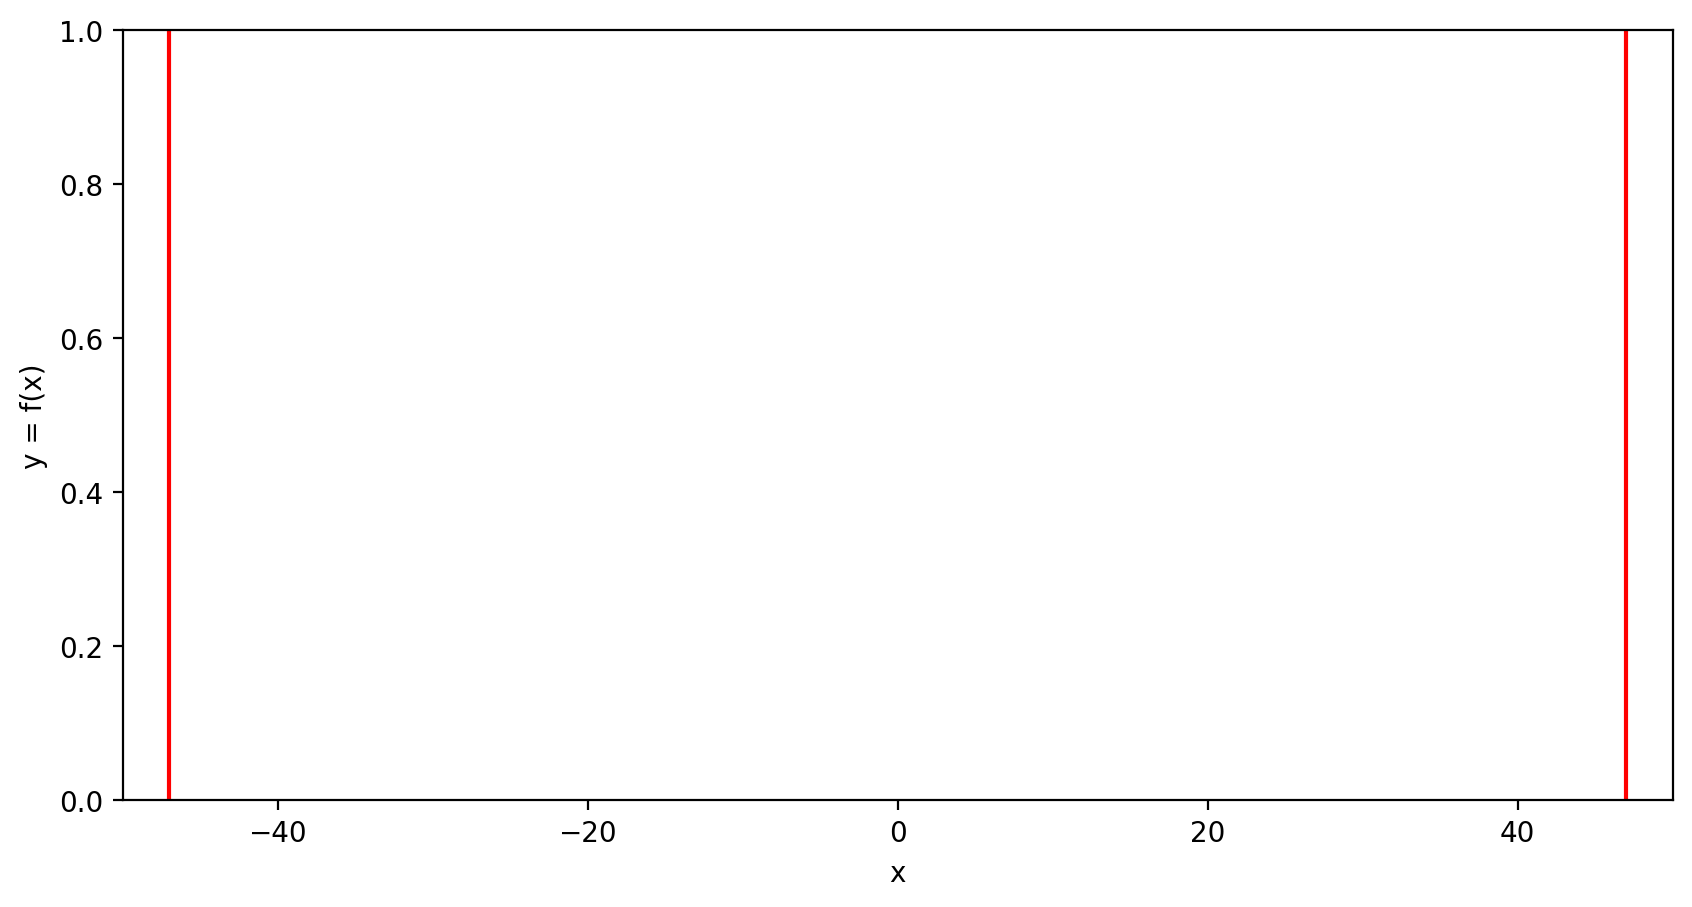

In [26]:
# Create the object separately in a cell
plotter = FunctionPlot(convex=False, bounds=50)

# Zeroth-order optimizers
* Black-box / derivative-free optimizers
    * Only access function's outputs
* Used extensively for hyper-parameter optimization
    * Decision variables are discrete (or mixed)
    * Discontinuous functions
        * Gradient and Hessian are not defined

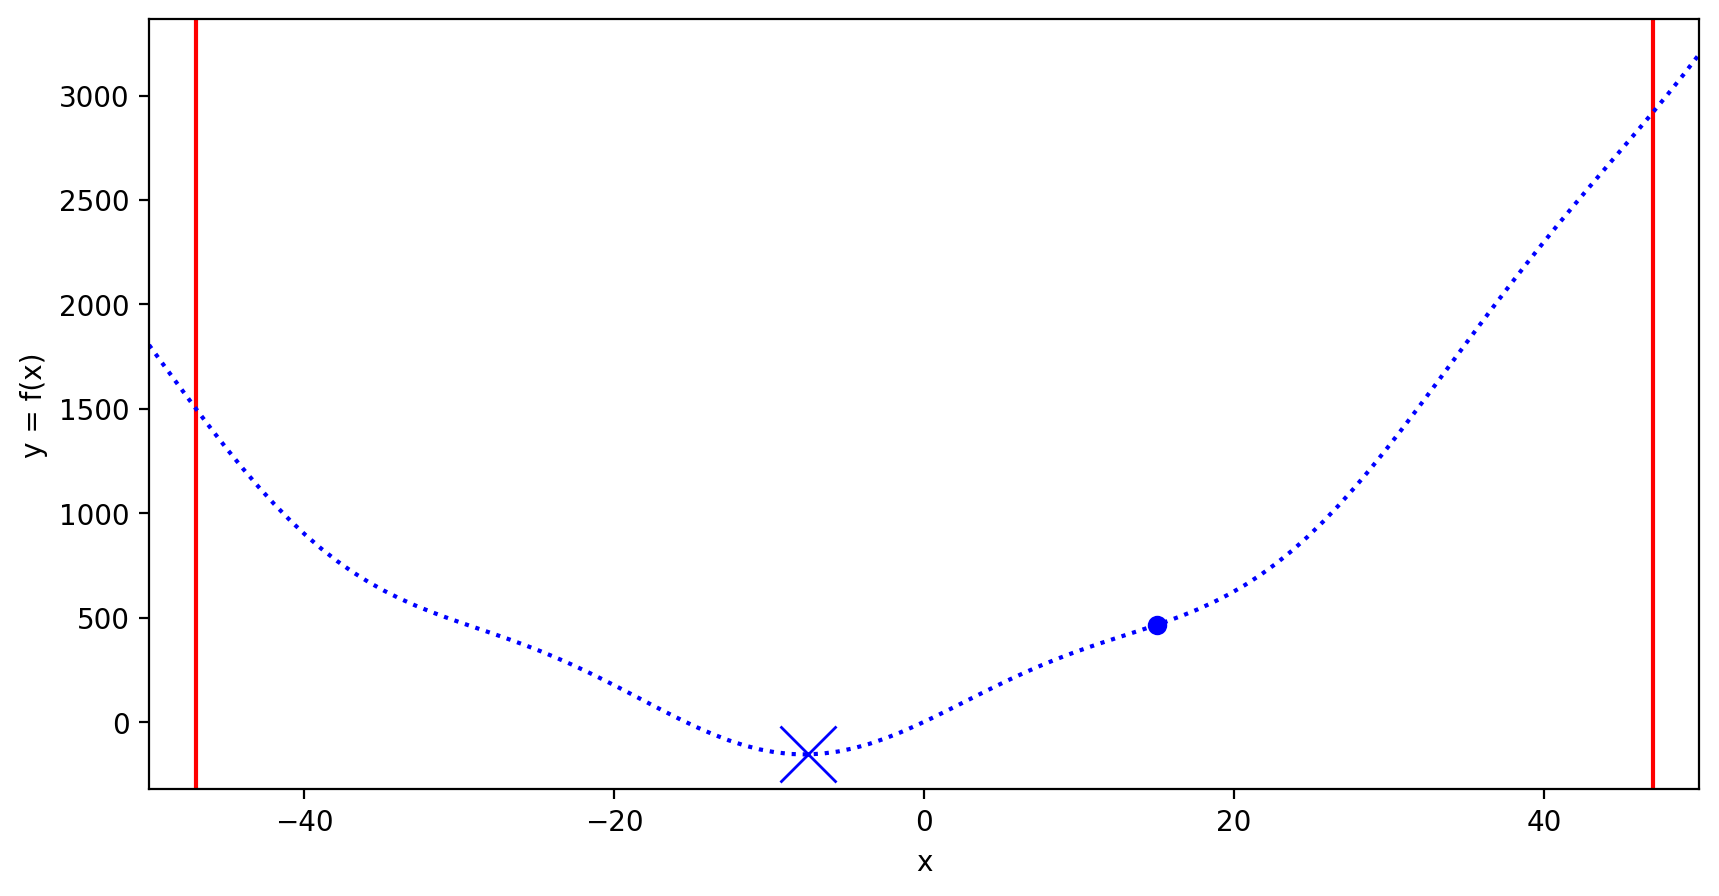

In [27]:
x = 15
plotter.plot(x)
plotter.plot_minimum()
plotter.plot_func()
plotter.fig

### Issues with Zeroth-order methods
* Not very efficient.
    * The number of function evaluations increases exponentially with dimensionality.
        * `Curse of dimensionality`.
* Never know when to stop!
    * **Cannot identify minima**

# How to know a minima if we see one

* Minima are defined as points better than their neighbourhood!
* To identify minima
    * Simply "Look" around a point
* We need a local model of the objective function

**Local model using Taylor series**


### $$ f(\vec{x} + \alpha \vec{p})|_{x=\vec{x}_0} \approx f(\vec{x}_0) + \alpha \nabla f(\vec{x}_0)^T \vec{p} + \frac{1} {2}\alpha^2 \vec{p}^T   \mathbf{H}(\vec{x}_0)   \vec{p}$$

$$ \text{Gradient = } ||\nabla f(\vec{x})|| = \Big[\frac{\partial f}{ \partial x_1}, \frac{\partial f}{ \partial x_2} ..., \frac{\partial f}{ \partial x_n} \Big]$$


$$ \text{Hessian = }H(\vec{x}) = \begin{bmatrix} \frac{\partial^2 f}{\partial x_1^2} & \cdots & \frac{\partial^2 f}{\partial x_1 \partial x_n} \\ \vdots &  \ddots & \vdots \\ \frac{\partial^2 f}{\partial x_n \partial x_1} & \cdots & \frac{\partial^2 f}{\partial x_n^2} \end{bmatrix} $$

**Need gradients and/or Hessian information**

## Optimality criteria

* Mathematical conditions to identify minima from other points!
* In practice,
    * Used internally by gradient-based optimizers
        * to find minima and to stop.
    * In constrained optimization
        * Optimality is checked with KKT (Karush-Kuhn-Tucker) conditions.

### First-order condition
* **At a local minimum, gradient should vanish.**
    * $\nabla f(\vec{x}_*) = 0$
<img align=right src="./figures/1d_optimality.png" width=50%>
* In 1D
    * Slope = 0 at every minimum (High school calculus!)
    * Gradient = collection of slopes
    * Gradient = 0 => Slope in every direction is zero
* If the gradient is non-zero
    * We can travel **opposite** to the gradient to reduce the function further.
    * (Remember that the gradient points in direction of largest increase!)


**Gradient is zero at other places too**
* Stationary points
    * Local maxima
    * Saddle points!
* So how do we check ?
    * Use more information!

### Second-order condition
* Based on the nature of the Hessian
* Hessian is the curvature matrix
    * Eigenvalues are curvatures along different directions
* Local minima
    * If Hessian = positive definite (all eigenvalues are > 0)
    * $H(x_*) > 0$
* Local maxima
    * If Hessian = negative definite (all eigenvalues < 0)
* Saddle point
    * If Hessian has positive and negative eigenvalues
* Not sure if it is semi-definite!

<img align=centre src="./figures/hessian_stationary_points.png" width=80%>

# Gradient-based optimizers

<img align=centre src="./figures/opt_spectrum.png" width=50%>

* Spectrum: from first order to second order
    * Based on Taylor series local model

**Common steps :**

#### 1. They need a guess to start - Initialization
#### 2. Update rule to make better guesses

## $$\vec{x}_{k+1} = \vec{x}_k + \alpha \times \vec{p}$$

* $\vec{p}$ is a **search direction**
    * Which direction to move ?
    * $\vec{p}$ depends on $\nabla f$
* $\alpha$ is a **step size**
    * How much to move along $\vec{p}$ 
#### 3. Stopping criteria
* E.g. $||\nabla f(\vec{x})|| \leq \epsilon$, $\epsilon$ is some tolerance

## Gradient descent (GD)

* Simplest gradient-based optimizer
    * Utilize only gradients
    * Pure first-order
* Search direction , $\vec{p} = - \nabla f$
    * Steepest descent!
    * We are decreasing the function's value most rapidly.
* Step size, $\alpha$ = scalar
    * Same for all directions
* **Stochastic gradient descent (SGD)**
    * Major ML/DL optimizer
    * Gradient is estimated using minibatches
    * Full batch SGD = GD!

### Choosing step size matters

<img align=right src="./figures/lr.png" width=40%>

* Most important hyper-parameter
    * For most gradient-based optimizers
    * = Learning rate!
* Too small, slow convergence
    * Less exploration
    * "Bad" local minimum
* Too large, diverge
    * Oscillations
* Useful strategy
    * Using a schedule and not a constant step size
        * E.g. Decrease the learning rate slowly
        * **Must for SGD! Why?**

### Question: Why use SGD instead of GD?

1. Huge datasets -> Need to be in memory for GD
2. Noise acts as regularization 

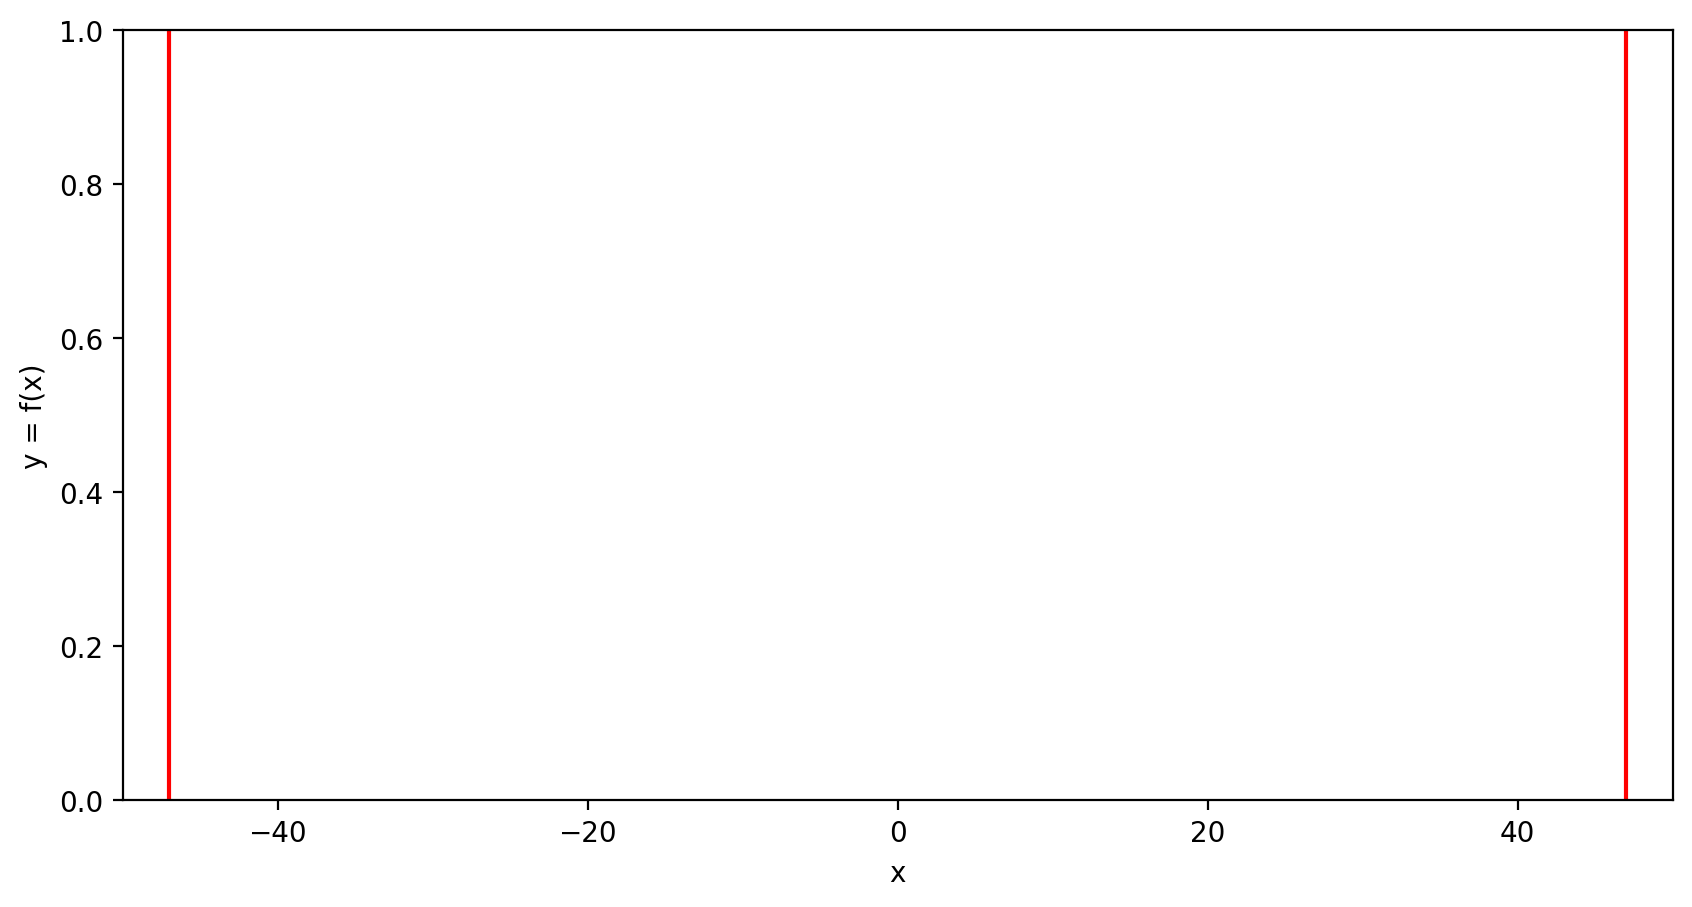

In [10]:
plotter = FunctionPlot(convex=True, bounds=50)

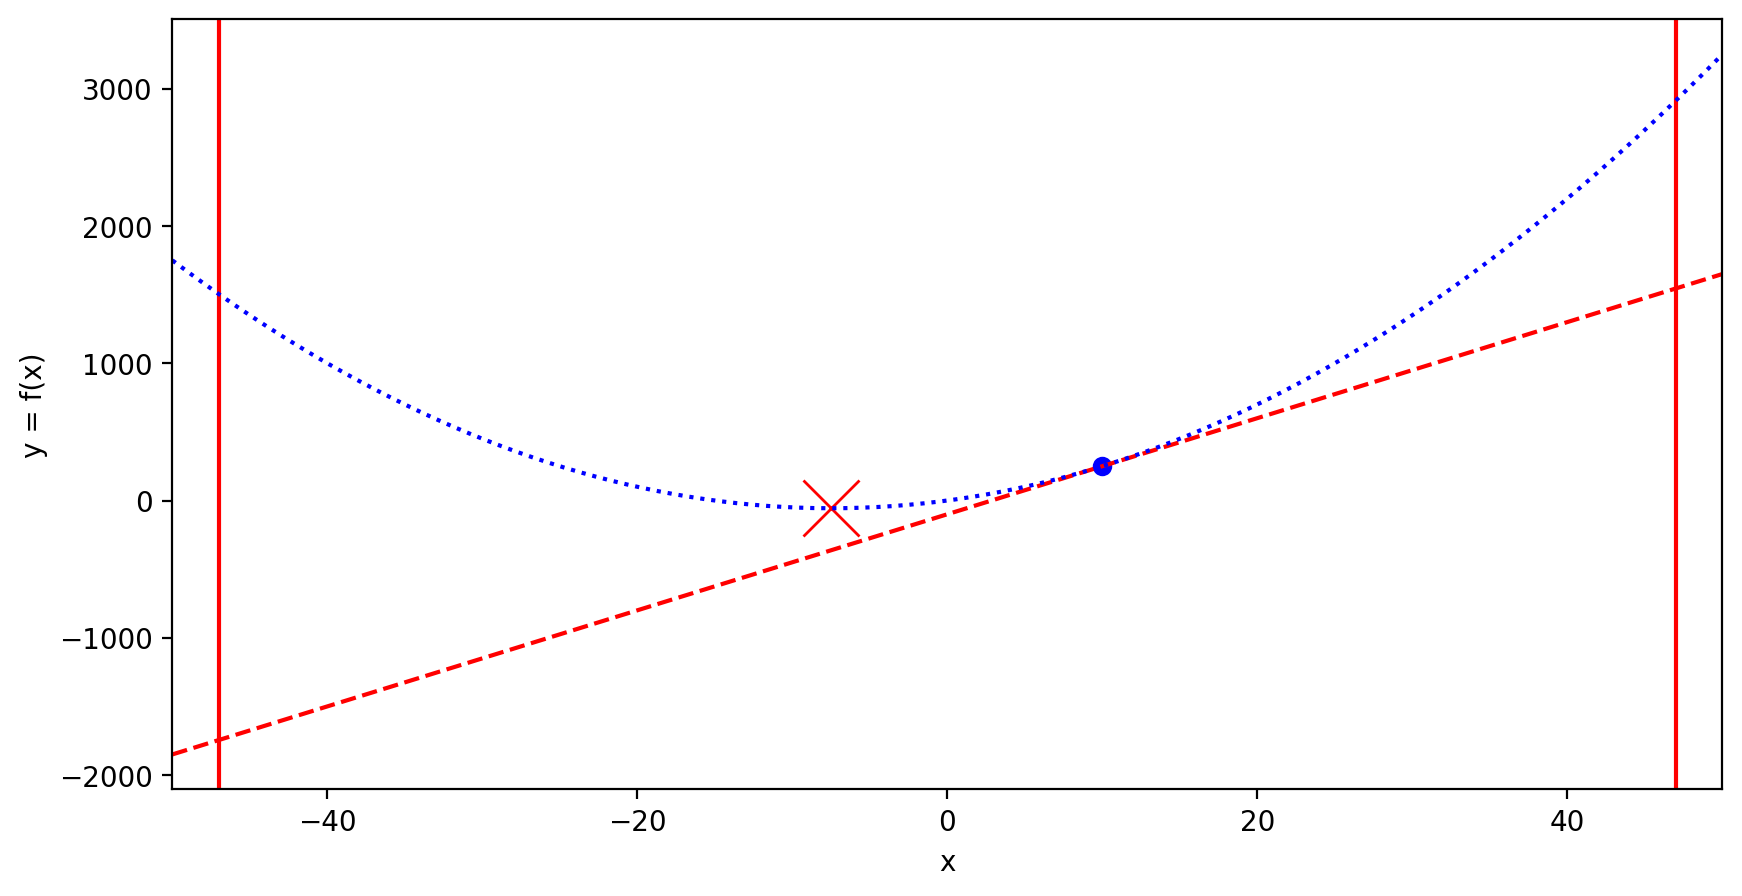

In [11]:
x = 10
plotter.plot(x, with_first_order=True)
plotter.plot_minimum()
plotter.plot_func()
plotter.fig

### Why not use GD always?

<img align=right src="./figures/gd_oscillation.png" width=50%>

* **Varying curvatures**
    * Imagine a 2D optimization
        * Decision variables : [length, thickness]
        * length ~ 1m to 2m
        * thickness ~ 1mm to 2mm
    
    * Gradient changes much faster in one direction than the other
    
    * Curvature along "length" axis <<<< Curvature along "thickness" axis [Scaling issues]

    * Hessian's eigenvalues
        * $[1000, 1]$
        
        
* *Slow progress along low curvature directions!*



**Two approaches to move forward** 
1. Adjust the gradients [to get a better search direction]
2. Adjust the step sizes individually

## Newton's method

* Most powerful methods in optimization
    * Uses both Gradient and Hessian
    * Creates a quadratic assumption
    * Goes to the quadratic bowl's minimum
* Direction, $\vec{p} = - \mathbf{H}^{-1} \nabla f$
    * This can be thought of as scaling the gradients according to the curvatures
    * Independent of variable scaling
* Step size, $\alpha = 1$

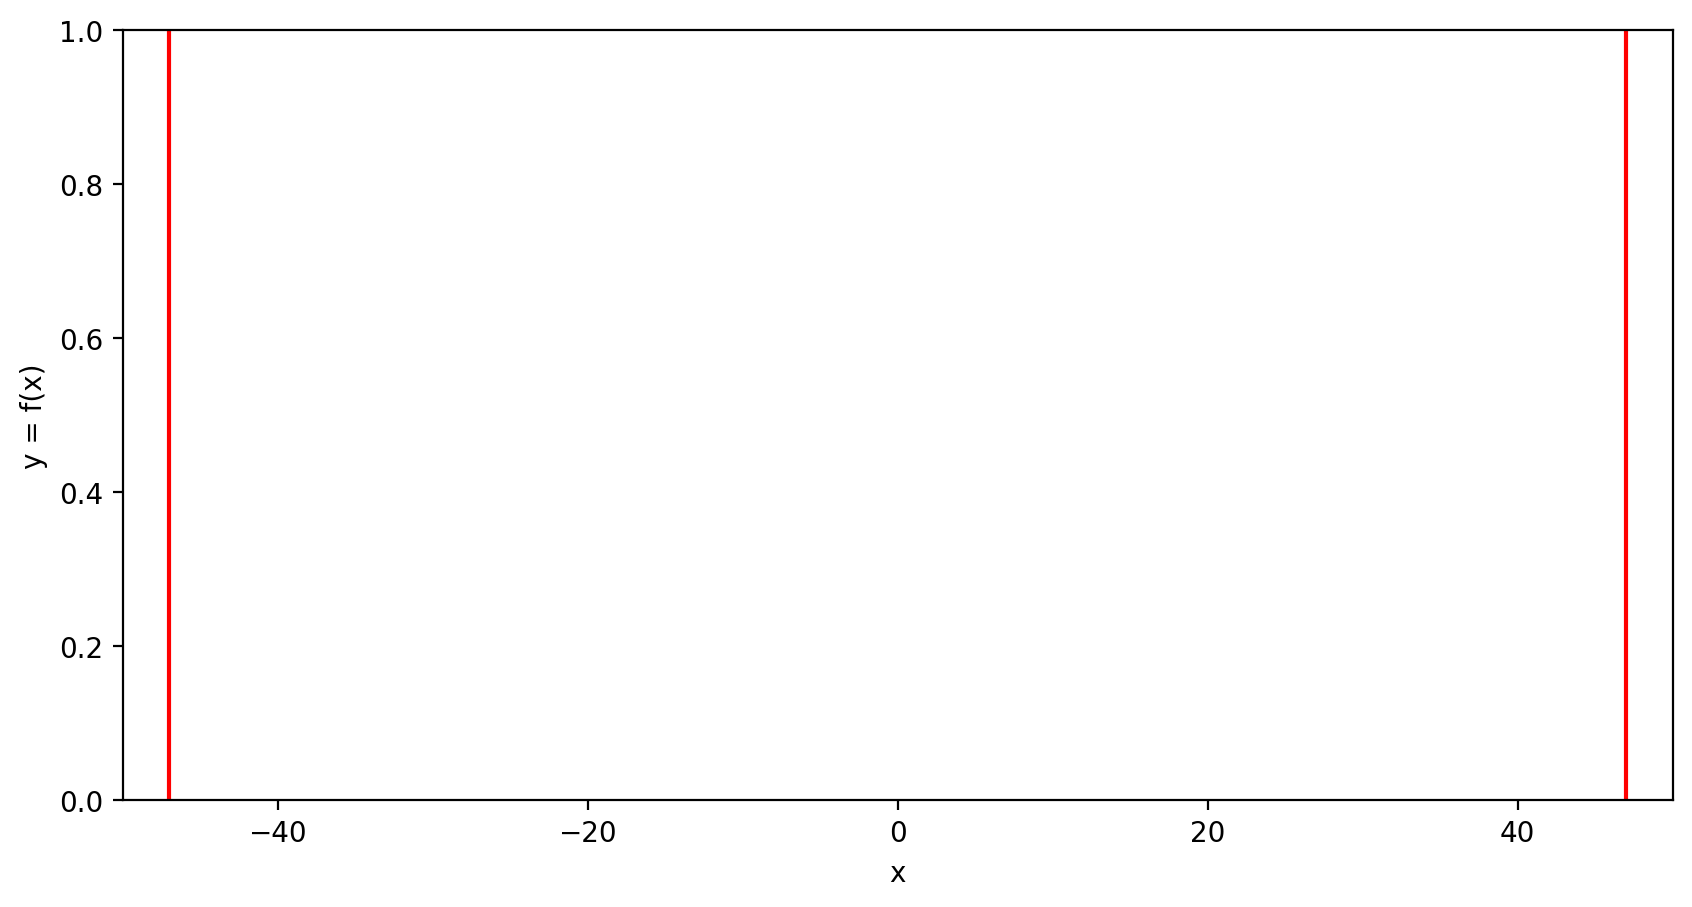

In [28]:
plotter = FunctionPlot(convex=True, bounds=50)

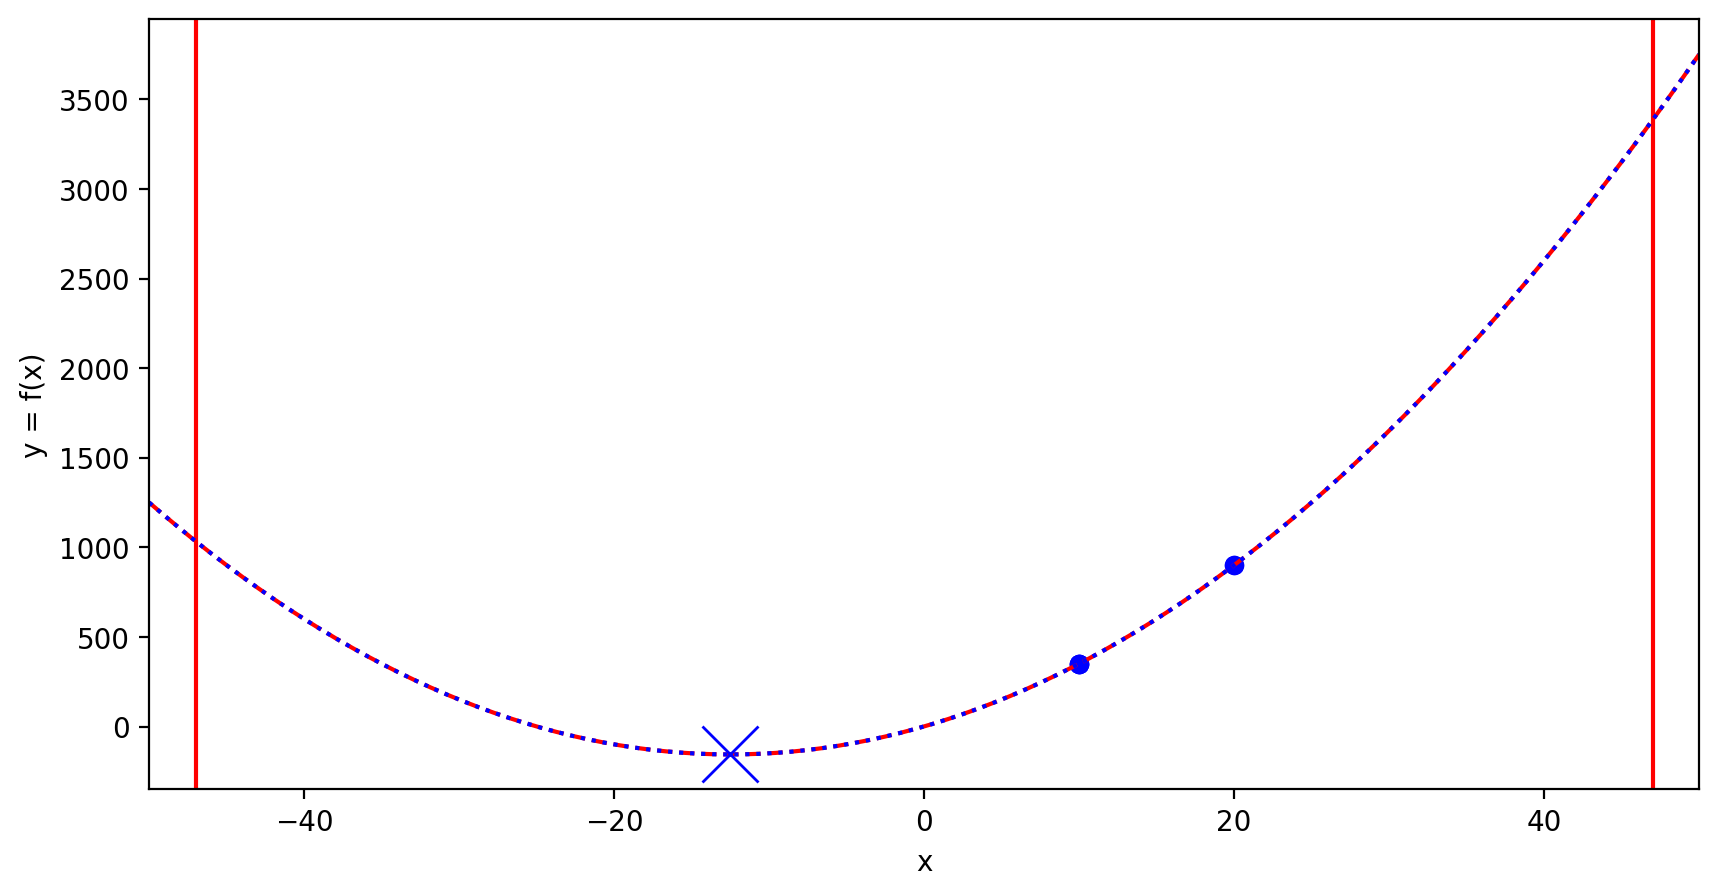

In [30]:
x = 10
plotter.plot(x, with_second_order=True)
plotter.plot_minimum()
plotter.plot_func()
plotter.fig

### Issues with Newton's method

* Calculating the Hessian
    * Storage
    * Expense
* Zero eigenvalues
    * Inversion does not exist
* Negative eigenvalues
    * Goes uphill 
        * They can cause the optimizer to increase the function!

### Quasi-newton methods

* Approximate the Hessian (or its inverse)
* $\vec{p} = - \mathbf{B}^{-1} \nabla f$
    * $\mathbf{B} \approx \mathbf{H}, \mathbf{B} > 0$
    * Positive definite approximation
* Constructing $\mathbf{B}$
    * Estimate curvature based on previous gradients!
* BFGS update formula is the most common
    * Based on storing all successive gradients 
    * Memory issues
        * L-BFGS (Store only last "m" gradients)

## Gradient descent with momentum

<img align=right src="./figures/gd_momentum.png" width=50%>

* "Heavy ball" momentum
* **Idea: Give more weightage to gradient directions that are consistent**
    * If there is oscillation in one direction, less weight for this

#### Procedure:
* Velocity vector (unit mass)
    * Exponentially weighted avergae of previous gradients
    * #### $\vec{v}_t = \beta \vec{v}_{t-1} - \alpha \nabla f$
        * $\beta$ is a scalar hyper-parameter
        * Controls importance of previous gradients 
* #### $x_{t+1} = x_{t} + \vec{v}_t$
    * $\vec{v}_t = \alpha \times [\frac{\beta}{\alpha} * (\mathbf{M - I}) * \nabla f]$
* Same step size for all directions, but modified direction

## Adagrad

* **Idea : Different step sizes for each direction**
    * Using a history of squared gradients

**Procedure**

Direction
* $\vec{p} = -\nabla f$ 

Step size
* Is now a vector, $\alpha^{'}$
* $\vec{a}_t = \vec{a}_{t-1} + \nabla f \odot \nabla f$
    * $\odot$ = element-wise product
### $$\alpha^{'} =  \frac{\alpha}{\epsilon + \sqrt{\vec{a}}}$$
* $\epsilon$ = small number to prevent division by zero
* $\alpha$ = scalar hyper-parameter


## Adam

**Adam = Momentum + Adagrad**

* Uses momentum's velocity as aspect (for past gradients)
    * $\beta_1$ hyper-parameter
* Modifies Adagrad with an exponential weighted average (for past squared gradients)
    * $\beta_2$ hyper-parameter
* Performs some bias correction for the estimates
* $\alpha$ hyper-parameter [learning-rate]

Exercise: Read the paper: [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980)

# Summary

* Zeroth-order optimizers
    * Only choice for black-box functions
    * Curse of dimensionality
* Optimality criteria
    * Gradient and Hessian to idenstify minima
* Gradient-based optimizers
    * General format - search direction and step size
* GD (SGD)
    * Simple but oscillates
* Newton's method
    * Robust to scaling but costly
* Adam
    * adaptive step size +  modified search direction